# Inference Tasks on Stellar Parameters to Stellar Spectra

In [1]:
import copy
import h5py
import torch
import matplotlib
import numpy as np
import pandas as pd
import pylab as plt
from xgboost import XGBRegressor
from astropy.stats import mad_std
from extinction import fitzpatrick99
from astroNN.gaia import fakemag_to_pc
from astroNN.shared.matplotlib import pylab_style
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

from stellarperceptron.model import StellarPerceptron

from utils.gaia_utils import xp_sampling_grid, xp_coeffs_phys, nn_xp_coeffs_phys, xp_spec_online
from utils.plotting_utils import setup_xp_physical_plot, top_cbar
from utils.empirical_utils import estimate_teff_from_logg_rgb

pylab_style(paper=True)

# ================== hardware-related settings ==================
device = "cuda:1"  #"cpu" for CPU or "cuda:x" for a NVIDIA GPU
mixed_precision = True
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False
# ================== hardware-related settings ==================

nn_model = StellarPerceptron.load("./model_torch/", mixed_precision=mixed_precision, device=device)

xp_apogee_testing = h5py.File("./data_files/testing_set.h5", mode="r")
xp_apogee_training = h5py.File("./data_files/training_set.h5", mode="r")

# this notebook is about inference from XP spectra, so we at least need XP spectra and APOGEE labels
good_idx = (
    (np.sum(np.isnan(xp_apogee_testing["raw"]["xp_coeffs_gnorm"][()]), axis=1) == 0)
    & ~np.isnan(xp_apogee_testing["raw"]["teff"][()])
    & ~np.isnan(xp_apogee_testing["raw"]["logg"][()])
    & ~np.isnan(xp_apogee_testing["raw"]["m_h"][()])
)

val_labels = np.column_stack(
    [
        xp_apogee_testing["raw"]["xp_coeffs_gnorm"][()],
        xp_apogee_testing["raw"]["bprp"][()],
        xp_apogee_testing["raw"]["jh"][()],
        xp_apogee_testing["raw"]["jk"][()],
        xp_apogee_testing["raw"]["teff"][()],
        xp_apogee_testing["raw"]["logg"][()],
        xp_apogee_testing["raw"]["m_h"][()],
        xp_apogee_testing["raw"]["logc19"][()],
        xp_apogee_testing["raw"]["g_fakemag"][()],
    ]
)[good_idx]

obs_names = np.stack(
    [
        *[f"bp{i}" for i in range(55)],
        *[f"rp{i}" for i in range(55)],
        "bprp",
        "jh",
        "jk",
        "teff",
        "logg",
        "m_h",
        "logebv",
        "g_fakemag",
    ]
)

# create pandas DataFrame for validation set
val_labels_pd = pd.DataFrame(data=val_labels, columns=obs_names)
test_data_length = len(val_labels_pd)

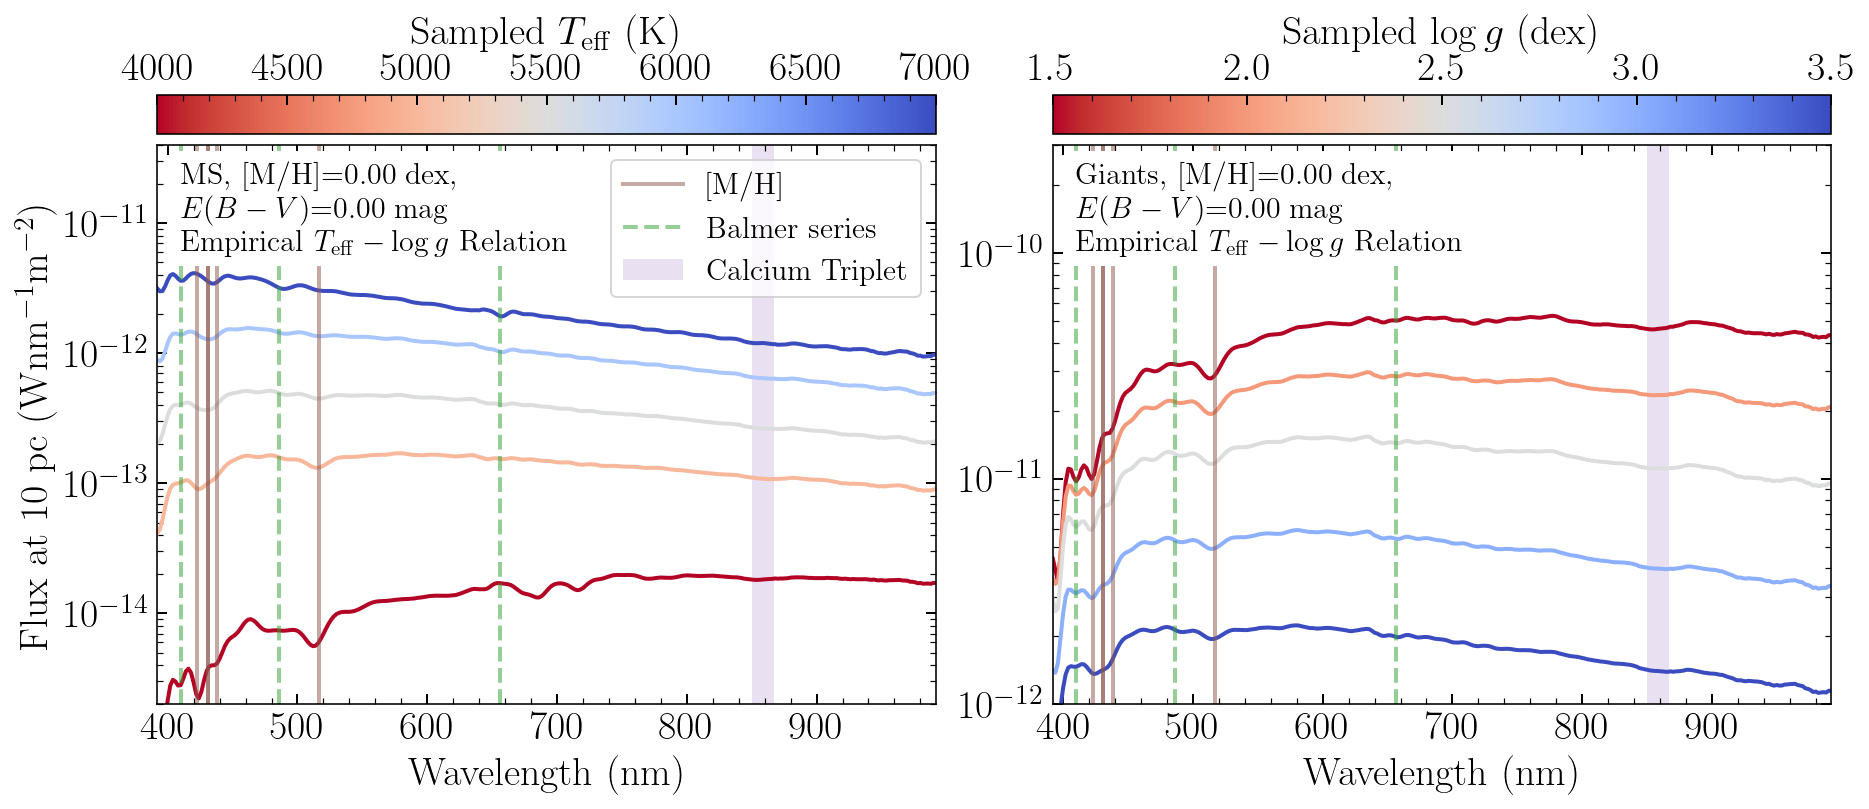

In [2]:
spectrum = nn_xp_coeffs_phys(nn_model, teff=7000.0, logg=3.95, m_h=0.0, logebv=-7., absolute_flux=True)
spectrum_2 = nn_xp_coeffs_phys(nn_model, teff=6000.0, logg=4.1, m_h=0.0, logebv=-7., absolute_flux=True)
spectrum_3 = nn_xp_coeffs_phys(nn_model, teff=5500.0, logg=4.3, m_h=0.0, logebv=-7., absolute_flux=True)
spectrum_4 = nn_xp_coeffs_phys(nn_model, teff=5000.0, logg=4.5, m_h=0.0, logebv=-7., absolute_flux=True)
spectrum_5 = nn_xp_coeffs_phys(nn_model, teff=4000.0, logg=4.6, m_h=0.0, logebv=-7., absolute_flux=True)

fig = plt.figure(figsize=(15, 5.5))
subfigs = fig.subfigures(1, 1)

(ax1, ax2) = subfigs.subplots(1, 2, gridspec_kw={"wspace": 0.15, "hspace": 0.1})

# ================================== Main Sequence ==================================

setup_xp_physical_plot(
    ax1,
    [spectrum, spectrum_2, spectrum_3, spectrum_4, spectrum_5],
    [7000.0, 6000.0, 5500.0, 5000.0, 4000.0],
    plt.cm.coolwarm_r,
    4000.0,
    7000.0,
    "Sampled $T_\mathrm{eff}$ (K)",
    lines_list=True,
)
ax1.annotate(
    "MS, [M/H]=0.00 dex,\n$E(B-V)$=0.00 mag\nEmpirical $T_\mathrm{eff}-\log{g}$ Relation",
    xy=(0.03, 0.97),
    xycoords=ax1,
    fontsize=15,
    ha="left",
    va="top",
    backgroundcolor="w",
)
ax1.set_yscale("log")
ax1.set_ylim(2*10**-15, 4*10**-11)
ax1.legend(loc="best")

# ================================== Giant ==================================
spectrum = nn_xp_coeffs_phys(
    nn_model, teff=4252.0, logg=1.5, m_h=0.0, logebv=-7, absolute_flux=True
)
spectrum_2 = nn_xp_coeffs_phys(
    nn_model, teff=4472.0, logg=2.0, m_h=0.0, logebv=-7, absolute_flux=True
)
spectrum_3 = nn_xp_coeffs_phys(
    nn_model, teff=4693.0, logg=2.5, m_h=0.0, logebv=-7, absolute_flux=True
)
spectrum_4 = nn_xp_coeffs_phys(
    nn_model, teff=4913.0, logg=3.0, m_h=0.0, logebv=-7, absolute_flux=True
)
spectrum_5 = nn_xp_coeffs_phys(
    nn_model, teff=5133.0, logg=3.5, m_h=0.0, logebv=-7, absolute_flux=True
)

setup_xp_physical_plot(
    ax2,
    [spectrum, spectrum_2, spectrum_3, spectrum_4, spectrum_5],
    [1.5, 2.0, 2.5, 3.0, 3.5],
    plt.cm.coolwarm_r,
    1.5,
    3.5,
    "Sampled $\log{g}$ (dex)",
    lines_list=True,
)

ax2.annotate(
    "Giants, [M/H]=0.00 dex,\n$E(B-V)$=0.00 mag\nEmpirical $T_\mathrm{eff}-\log{g}$ Relation",
    xy=(0.03, 0.97),
    xycoords=ax2,
    fontsize=15,
    ha="left",
    va="top",
    backgroundcolor="w",
)
ax2.set_ylim(1 * 10**-12, 3 * 10**-10)
ax2.set_yscale("log")
ax2.set_ylabel(None)

# subfigs.suptitle("$\\underline{\\mathrm{NN\,Spectra\,for\,Sampled\,Physical\,Parameters}}$", fontsize=20)
fig.savefig("./figs/spec_teff_logg_abs.pdf", bbox_inches="tight")


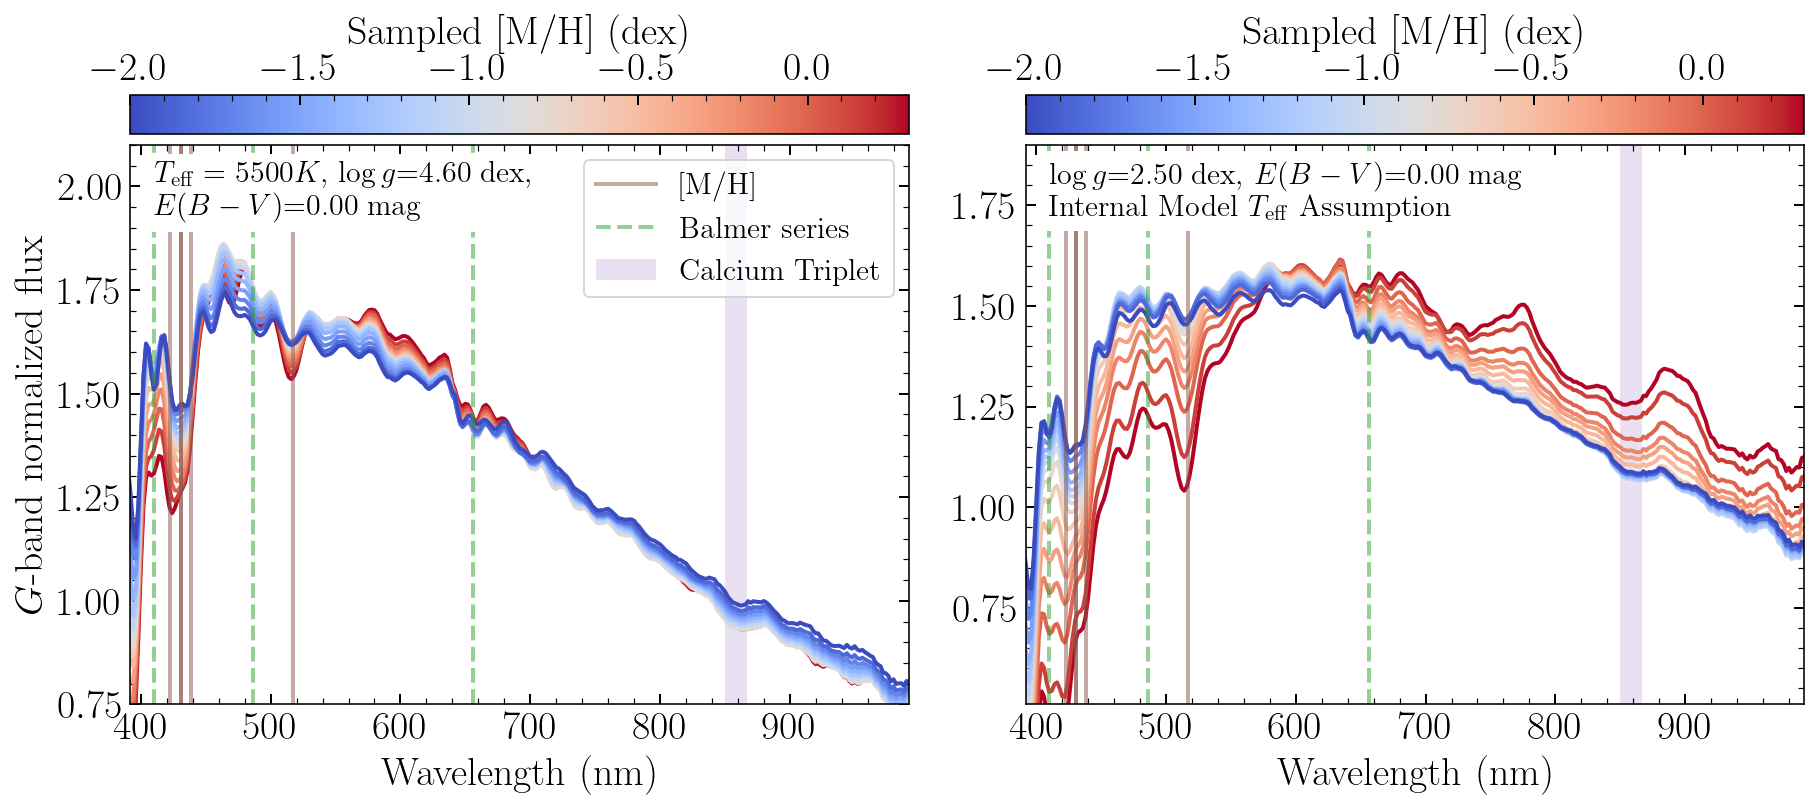

In [3]:
fig = plt.figure(figsize=(15, 5.5))
subfigs = fig.subfigures(1, 1)
(ax1, ax2) = subfigs.subplots(1, 2, gridspec_kw={"wspace": 0.15, "hspace": 0.0})
# ================================== Main Sequence ==================================
mhs = np.linspace(0.3, -2.0, 16)
spec_ls = [
    nn_xp_coeffs_phys(nn_model, teff=5500.0, logg=4.6, m_h=i, logebv=-7.0) for i in mhs
]

setup_xp_physical_plot(
    ax1,
    spec_ls,
    mhs,
    plt.cm.coolwarm,
    -2.0,
    0.3,
    "Sampled [M/H] (dex)",
    lines_list=True,
    logscale=-21,
)


ax1.annotate(
    "$T_\mathrm{eff}=5500K$, $\log{g}$=4.60 dex,\n$E(B-V)$=0.00 mag",
    xy=(0.03, 0.97),
    xycoords=ax1,
    fontsize=15,
    ha="left",
    va="top",
    backgroundcolor="w",
)
ax1.set_ylabel("$G$-band normalized flux")
ax1.set_ylim(0.75, 2.1)
ax1.legend(loc="best")

# ================================== Giant ==================================
mhs = np.linspace(0.3, -2.0, 16)
spec_ls = [nn_xp_coeffs_phys(nn_model, logg=2.5, m_h=i, logebv=-6.0) for i in mhs]

setup_xp_physical_plot(
    ax2,
    spec_ls,
    mhs,
    plt.cm.coolwarm,
    -2.0,
    0.3,
    "Sampled [M/H] (dex)",
    lines_list=True,
    logscale=-21,
)

ax2.annotate(
    "$\log{g}$=2.50 dex, $E(B-V)$=0.00 mag\nInternal Model $T_\mathrm{eff}$ Assumption",
    xy=(0.03, 0.97),
    xycoords=ax2,
    fontsize=15,
    ha="left",
    va="top",
    backgroundcolor="w",
)
ax2.set_ylim(0.51, 1.9)
ax2.set_ylabel(None)
fig.savefig("./figs/spec_mh.pdf", bbox_inches="tight")


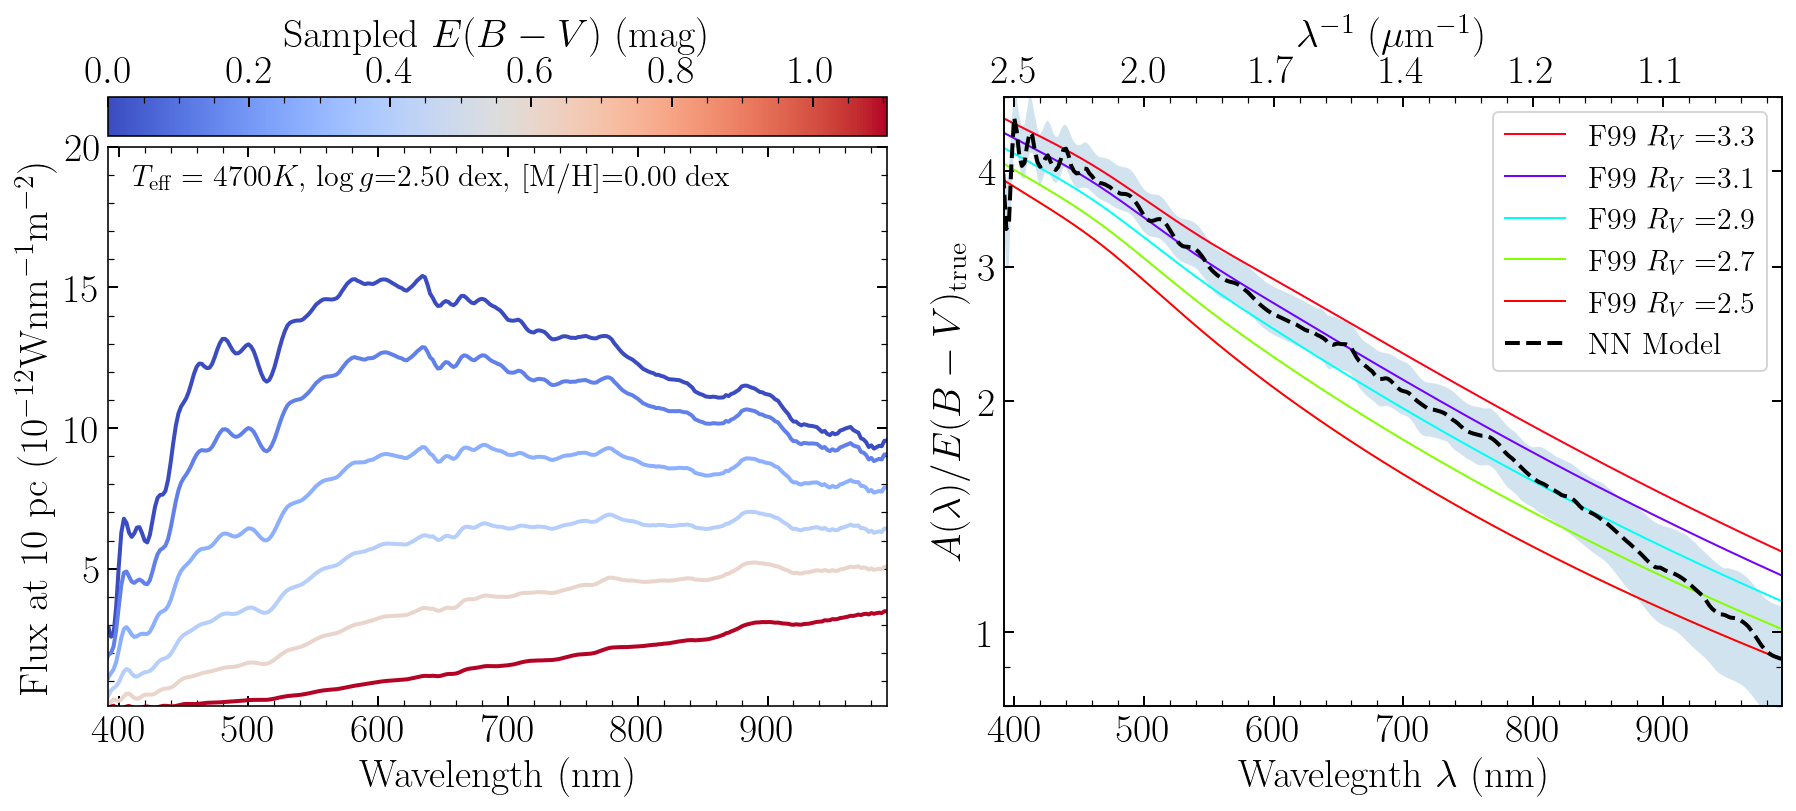

In [2]:
fig = plt.figure(figsize=(15, 5.5))
subfigs = fig.subfigures(1, 1)
(ax1, ax2) = subfigs.subplots(1, 2, gridspec_kw={"wspace": 0.15, "hspace": 0.0})

# ================================== Extinction with Physical Spectra ==================================
logebvs = [-6.0, -2.0, -1.3, -0.9, -0.5, 0.1]
spec_ls = [nn_xp_coeffs_phys(nn_model, teff=4700.0, logg=2.5, m_h=0.0, logebv=i, absolute_flux=True) for i in logebvs]

setup_xp_physical_plot(
    ax1,
    spec_ls,
    np.exp(logebvs),
    plt.cm.coolwarm,
    0.,
    np.exp(0.1),
    "Sampled $E(B-V)$ (mag)",
    logscale=-12,
)
ax1.annotate(
    "$T_\mathrm{eff}=4700K$, $\log{g}$=2.50 dex, [M/H]=0.00 dex",
    xy=(0.03, 0.97),
    xycoords=ax1,
    fontsize=15,
    ha="left",
    va="top",
)
ax1.set_ylim(0.1, 20)

# ================================== Extinction Curve calculated ==================================
norm = matplotlib.colors.Normalize(vmin=2.5, vmax=3.3)
cmap = plt.cm.hsv
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
plot_legend = True
for r_v in [3.3, 3.1, 2.9, 2.7, 2.5]:
    label = f"F99 $R_V=${r_v:.1f}"
    # 0.86 for SF 2011 scaling
    ax2.plot(xp_sampling_grid, fitzpatrick99(xp_sampling_grid*10,r_v,unit="aa",r_v=r_v), color=matplotlib.colors.to_hex(cmap(norm(r_v))), label=label)

logebvs = [-6.0, -2.0, -1.3, -0.9, -0.5, -0.0]
spec_ls = [nn_xp_coeffs_phys(nn_model, teff=4700.0, logg=2.5, m_h=0.0, logebv=i, absolute_flux=True) for i in logebvs]

spec_ls_no_extinction = []
spec_ls_some_extinction = []  # E(B-V) = 0.4 mag
spec_ls_high_extinction = []  # E(B-V) = 0.8 mag
spec_ls_ultra_extinction = []  # E(B-V) = 1.2 mag

for base_logg in np.arange(1.0, 2.5, 0.1):
    base_teff = estimate_teff_from_logg_rgb(base_logg)
    spec_ls_no_extinction.append(nn_xp_coeffs_phys(nn_model, teff=base_teff, logg=base_logg, m_h=0.0, logebv=-6, truncation=48, absolute_flux=True))
    spec_ls_some_extinction.append(nn_xp_coeffs_phys(nn_model, teff=base_teff, logg=base_logg, m_h=0.0, logebv=-0.916290731874155, truncation=48, absolute_flux=True))
    spec_ls_high_extinction.append(nn_xp_coeffs_phys(nn_model, teff=base_teff, logg=base_logg, m_h=0.0, logebv=-0.2231435513142097, truncation=48, absolute_flux=True))
    spec_ls_ultra_extinction.append(nn_xp_coeffs_phys(nn_model, teff=base_teff, logg=base_logg, m_h=0.0, logebv=0.1823215567939546, truncation=48, absolute_flux=True))

some_extinction_cruves = [-np.log(x / y) / 0.4 / 0.884 for x, y in zip(spec_ls_some_extinction, spec_ls_no_extinction)]
high_extinction_cruves = [-np.log(x / y) / 0.8 / 0.884 for x, y in zip(spec_ls_high_extinction, spec_ls_no_extinction)]
ultra_extinction_cruves = [-np.log(x / y) / 1.2 / 0.884 for x, y in zip(spec_ls_ultra_extinction, spec_ls_no_extinction)]
inferred_extinction_cruves = np.vstack([some_extinction_cruves, high_extinction_cruves, ultra_extinction_cruves])
mean_inferred_extinction_cruves = np.nanmedian(inferred_extinction_cruves, axis=0)
lower_inferred_extinction_cruves = np.nanpercentile(inferred_extinction_cruves, 16, axis=0)
upper_inferred_extinction_cruves = np.nanpercentile(inferred_extinction_cruves, 84, axis=0)
ax2.fill_between(xp_sampling_grid, lower_inferred_extinction_cruves, upper_inferred_extinction_cruves, alpha=0.2)
ax2.plot(xp_sampling_grid, mean_inferred_extinction_cruves, ls="--", lw=2, c="k", label="NN Model")

ax2.set_xlim(392, 992)
ax2.set_xlabel("Wavelegnth $\\lambda$ (nm)")
ax2.set_ylabel("$A(\lambda) / E(B-V)_\mathrm{true}$")
ax2.set_yscale("log")
ax2.set_ylim(0.8, 5.)
ax2.legend(loc="best")
ax2.set_yticks([1, 2, 3, 4])
ax2.set_yticklabels(["1", "2", "3", "4"])

ax3 = ax2.twiny()
new_tick_locations = np.array([400, 500, 600, 700, 800, 900])

def tick_function(x):
    ix = 1000 / x
    return ["%.1f" % z for z in ix]

ax3.set_xlim(ax1.get_xlim())
ax3.set_xticks(new_tick_locations)
ax3.set_xticklabels(tick_function(new_tick_locations))
ax3.set_xlabel("$\\lambda^{-1}$ ($\\mu \mathrm{m}^{-1}$)")

fig.savefig("./figs/spec_extinction.pdf", bbox_inches="tight")

c:\Users\Henry\miniconda3\Lib\site-packages\zero_point\zpt.py:163: UserWarning: Warning: converting a masked element to nan.
c:\Users\Henry\miniconda3\Lib\site-packages\zero_point\zpt.py:163: UserWarning: Warning: converting a masked element to nan.
c:\Users\Henry\miniconda3\Lib\site-packages\zero_point\zpt.py:163: UserWarning: Warning: converting a masked element to nan.
c:\Users\Henry\miniconda3\Lib\site-packages\zero_point\zpt.py:163: UserWarning: Warning: converting a masked element to nan.


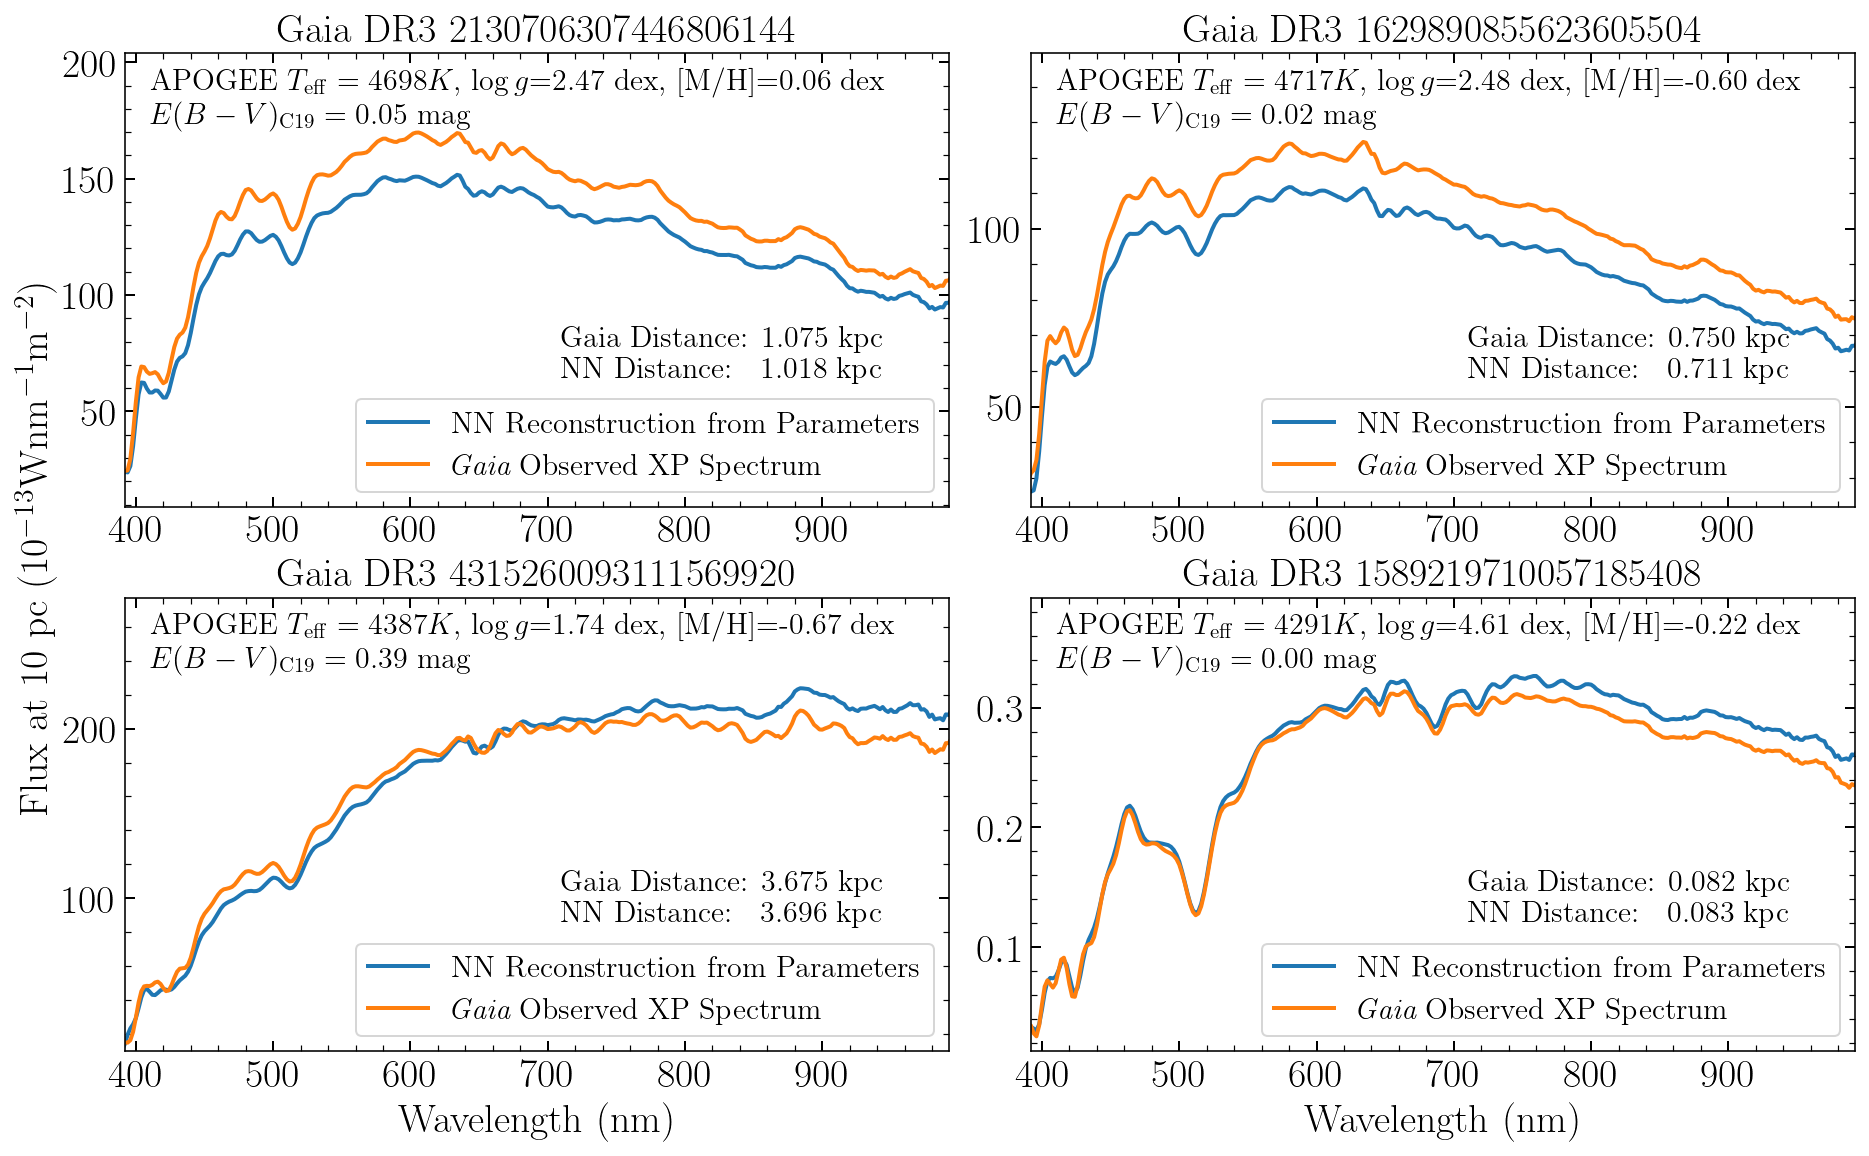

In [6]:
fig = plt.figure(figsize=(15.5, 9))
subfigs = fig.subfigures(1, 1)

((ax1, ax2), (ax3, ax4)) = subfigs.subplots(2, 2, gridspec_kw={"wspace": 0.1})


def plot_spec_online(ax, gdr3_source_id, teff, logg, m_h, logebv, absolute_flux=True):
    normalization_factor = 1e-13
    bprp_coeffs, additional_result = xp_spec_online(gdr3_source_id, absolute_flux=True, return_info=True)
    gaia_observed_spec = xp_coeffs_phys(bprp_coeffs) / normalization_factor
    gaia_dist = 1 / additional_result["plx"]
    spectrum, nn_result = nn_xp_coeffs_phys(nn_model, teff=teff, logg=logg, m_h=m_h, logebv=logebv, absolute_flux=absolute_flux, return_df=True)
    nn_dist = fakemag_to_pc(nn_result["g_fakemag"][0], additional_result["mag"]).value / 1000
    spectrum_1 = spectrum / normalization_factor

    # ax.set_title(f"Gaia DR3 {gdr3_source_id}")
    ax.set_title(f"Gaia DR3 {gdr3_source_id}")
    ax.plot(xp_sampling_grid, spectrum_1, lw=2, label="NN Reconstruction from Parameters")
    ax.plot(xp_sampling_grid, gaia_observed_spec, lw=2, label="$\\textit{Gaia}$ Observed XP Spectrum")
    ax.annotate(
        f"APOGEE $T_\mathrm{{eff}}={teff:.0f} K$, $\log{{g}}$={logg:.2f} dex, [M/H]={m_h:.2f} dex\n $E(B-V)_\mathrm{{C19}}={np.exp(logebv):.2f}$ mag",
        xy=(0.03, 0.97),
        xycoords=ax,
        fontsize=15,
        ha="left",
        va="top",
        # backgroundcolor=None,
    )

    ax.annotate(
        f"Gaia Distance: {gaia_dist:.3f} kpc\nNN Distance: $\,$ {nn_dist:.3f} kpc",
        xy=(0.53, 0.4),
        xycoords=ax,
        fontsize=15,
        ha="left",
        va="top",
        # backgroundcolor=None,
    )

    ax.set_ylim(np.min([spectrum_1, gaia_observed_spec]), np.max([spectrum_1, gaia_observed_spec])*1.2)
    ax.set_xlabel("Wavelength (nm)")
    # ax.set_ylabel("$10pc$ Flux ($10^{-13} W nm^{-1} m^{-2}$)")
    ax.set_xlim(392, 992)
    ax.legend(loc="lower right")

plot_spec_online(ax1, 2130706307446806144, teff=4698.3677, logg=2.4654598, m_h=0.059084, logebv=-2.9957323331586374, absolute_flux=True)
ax1.set_xlabel(None)
plot_spec_online(ax2, 1629890855623605504, teff=4717.464, logg=2.4766452, m_h=-0.60218, logebv=-3.912023027779888, absolute_flux=True)
ax2.set_xlabel(None)
plot_spec_online(ax3, 4315260093111569920, teff=4386.8984, logg=1.7397821, m_h=-0.67223, logebv=-0.9490805546971459, absolute_flux=True)
plot_spec_online(ax4, 1589219710057185408, teff=4291.101, logg=4.6053257, m_h=-0.22369, logebv=-7., absolute_flux=True)
ax2.set_ylabel("")
ax4.set_ylabel("")
subfigs.text(0.085,0.5, "Flux at 10 pc ($10^{-13} \mathrm{{W}} \mathrm{{nm}}^{{{-1}}} \mathrm{{m}}^{{{-2}}}$)", ha="center", va="center", rotation=90, fontsize=20, transform=subfigs.transFigure)
# subfigs.supylabel("Flux at $10pc$ ($10^{-13} W nm^{-1} m^{-2}$)")
# fig.text(0.1, 0.5, 'Flux at $10pc$ ($10^{-13} W nm^{-1} m^{-2}$)', va='center', rotation='vertical', fontsize=20, transform=fig.transFigure)
fig.savefig("./figs/spec_comparison.pdf", bbox_inches="tight")

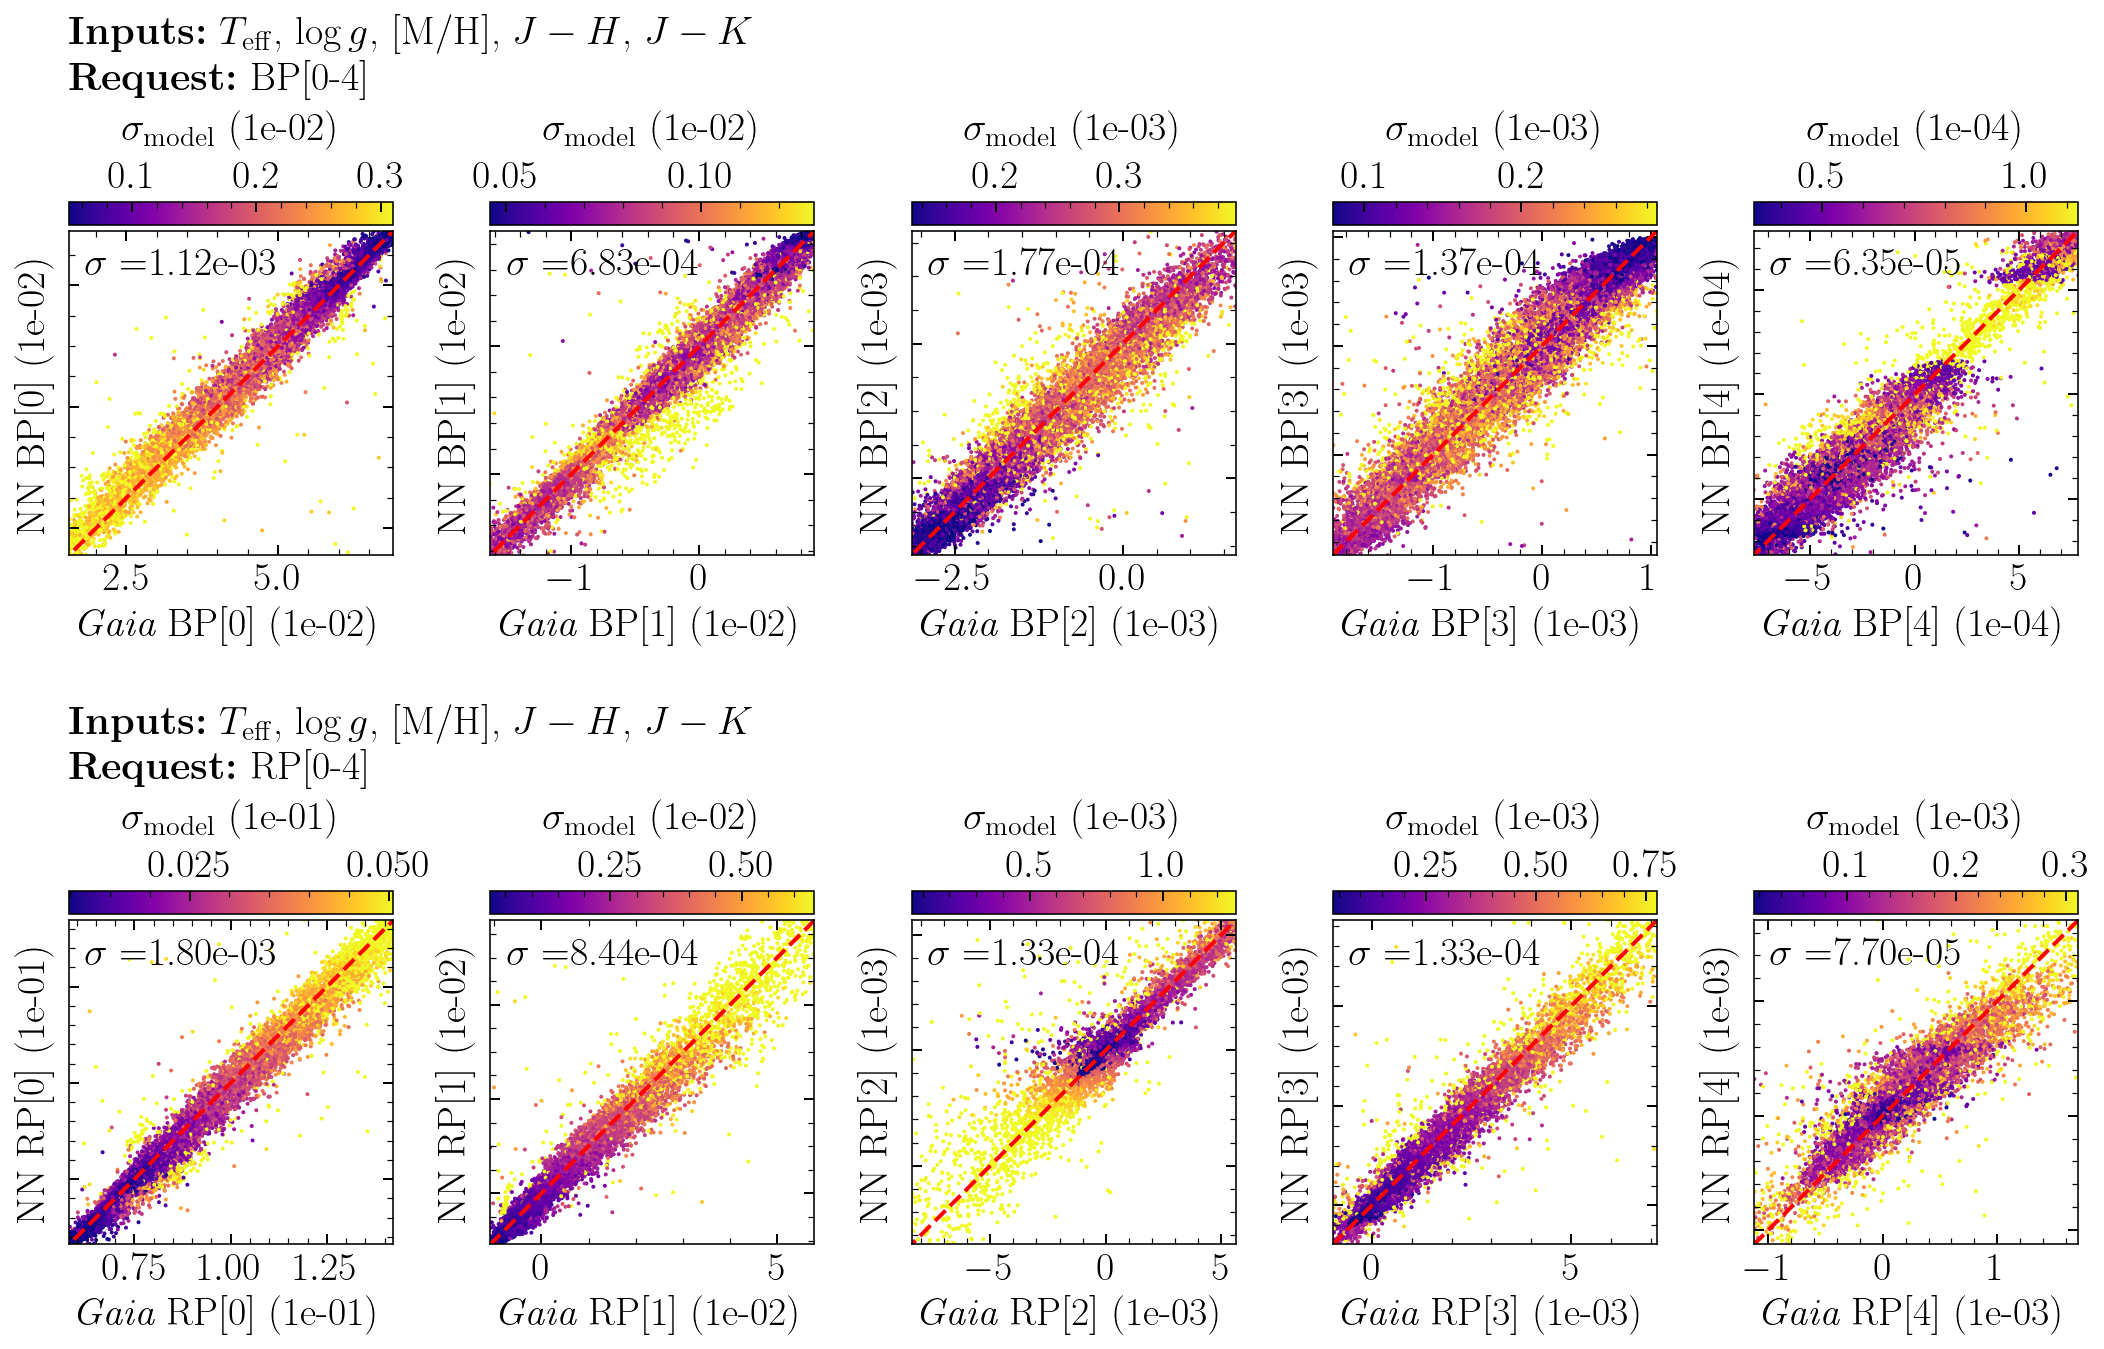

In [9]:
col_names = ["teff", "logg", "m_h", "jh", "jk"]
val_labels_shuffled = val_labels_pd[col_names]
val_labels_names = np.tile(col_names, (test_data_length, 1))
nn_model.clear_perception()
nn_model.perceive(
    val_labels_shuffled,
    val_labels_names,
)
pred_df = nn_model.request(
    [*[f"bp{i}" for i in range(6)], *[f"rp{i}" for i in range(6)]]
)
nn_model.clear_perception()

fig = plt.figure(figsize=(18, 11))
subfigs = fig.subfigures(1, 1)
# ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8))
axes = subfigs.subplots(2, 5, gridspec_kw={"wspace": 0.3, "hspace": 0.3})

normalizing_factor = [[1e-2, 1e-2, 1e-3, 1e-3, 1e-4], [1e-1, 1e-2, 1e-3, 1e-3, 1e-3]]

for idx, (xp, nfs) in enumerate(zip(["bp", "rp"], normalizing_factor)):
    for i, nf in zip(range(5), nfs):
        xmin = np.percentile(val_labels_pd[f"{xp}{i}"] / nf, 1)
        xmax = np.percentile(val_labels_pd[f"{xp}{i}"] / nf, 99)
        cmin = np.percentile(pred_df[f"{xp}{i}_error"] / nf, 5)
        cmax = np.percentile(pred_df[f"{xp}{i}_error"] / nf, 95)
        mappable = axes[idx, i].scatter(
            val_labels_pd[f"{xp}{i}"] / nf,
            pred_df[f"{xp}{i}"] / nf,
            c=pred_df[f"{xp}{i}_error"] / nf,
            vmin=cmin,
            vmax=cmax,
            s=1,
            cmap="plasma",
            rasterized=True,
        )
        axes[idx, i].annotate(
            f"$\\sigma=${mad_std(val_labels_pd[f'{xp}{i}'] - pred_df[f'{xp}{i}'], ignore_nan=True):.2e}",
            xy=(0.05, 0.95),
            xycoords=axes[idx, i],
            fontsize=20,
            ha="left",
            va="top",
        )
        axes[idx, i].ticklabel_format(axis="both", style="sci", scilimits=(0, 0))
        axes[idx, i].plot([-10, 10], [-10, 10], lw=2, ls="--", c="r")
        axes[idx, i].set_xlim(xmin, xmax)
        axes[idx, i].set_ylim(xmin, xmax)
        axes[idx, i].set_yticklabels([])
        axes[idx, i].set_xlabel(f"$\\textit{{Gaia}}$ {xp.upper()}[{i}] ({nf:.0e})")
        axes[idx, i].set_ylabel(f"NN {xp.upper()}[{i}] ({nf:.0e})")
        axes[idx, i].set_aspect("equal", "box")
        cbar = top_cbar(
            axes[idx, i],
            mappable,
            f"$\sigma_\mathrm{{model}}$  ({nf:.0e})",
            labelpad=10,
        )
axes[0, 0].set_title("$\\textbf{Inputs:}$ $T_\mathrm{eff}$, $\log{g}$, [M/H], $J-H$, $J-K$\n$\\textbf{Request:}$ BP[0-4]", fontsize=20, x=0.00, y=1.4, ha="left")
axes[1, 0].set_title("$\\textbf{Inputs:}$ $T_\mathrm{eff}$, $\log{g}$, [M/H], $J-H$, $J-K$\n$\\textbf{Request:}$ RP[0-4]", fontsize=20, x=0.00, y=1.4, ha="left")

fig.savefig("./figs/xp_coeffs.pdf", bbox_inches="tight", dpi=150)

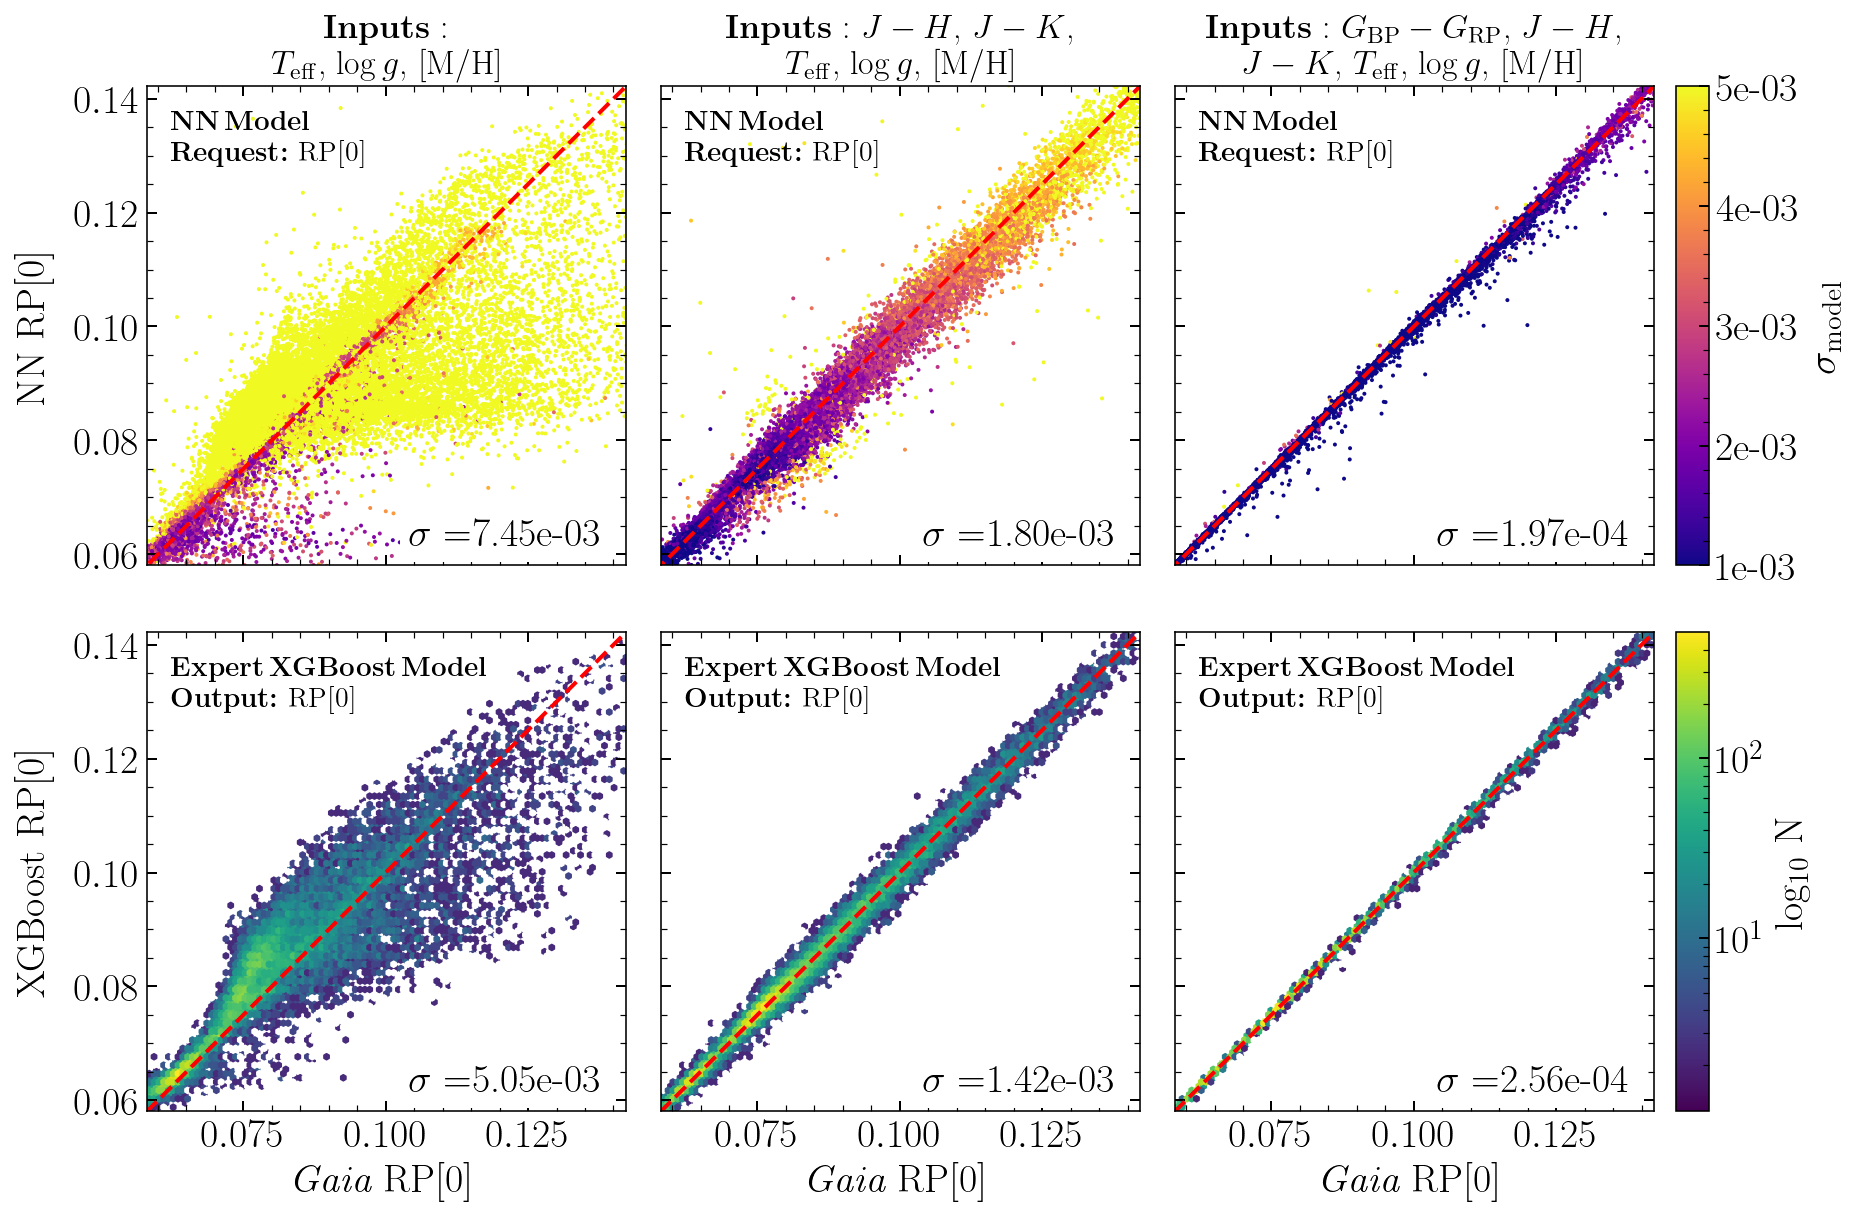

In [5]:
def plot_rp0(ax, x, y, y_err=None, cmap="viridis", text=None):
    xmin = np.percentile(x, 1)
    xmax = np.percentile(x, 99)
    if y_err is None:
        custom_cmap = copy.copy(plt.get_cmap(cmap))
        custom_cmap.set_under(color="white")
        mappable = ax.hexbin(
            x,
            y,
            bins="log",
            extent=[xmin, xmax, xmin, xmax],
            cmap=custom_cmap,
            vmin=1.1,
            rasterized=True,
        )
    else:
        mappable = ax.scatter(
            x,
            y,
            c=y_err,
            cmap=cmap,
            vmin=1e-3,
            vmax=5e-3,
            s=1,
            rasterized=True,
        )
    if text:
        ax.annotate(text, xy=(0.05, 0.95), xycoords=ax, fontsize=14, ha="left", va="top")
    ax.annotate(
        f"$\\sigma=${mad_std(x-y, ignore_nan=True):.2e}",
        xy=(0.95, 0.10),
        xycoords=ax,
        fontsize=20,
        ha="right",
        va="top",
        backgroundcolor="white",
    )
    ax.plot([-1, 3], [-1, 3], lw=2, ls="--", c="r")
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(xmin, xmax)
    ax.set_aspect("equal", "box")
    return mappable

# ===================================== Setup Figure =====================================
fig = plt.figure(figsize=(14.0, 9.8))
subfigs = fig.subfigures(1, 1)
((ax1, ax2, ax3), (ax4, ax5, ax6)) = subfigs.subplots(
    2, 3, gridspec_kw={"wspace": 0.07, "hspace": 0.01, "width_ratios": [1, 1, 1.115]}
)

ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax3.set_xticklabels([])
ax2.set_yticklabels([])
ax3.set_yticklabels([])
ax5.set_yticklabels([])
ax6.set_yticklabels([])
ax4.set_xlabel("$\emph{Gaia}$ RP[0]")
ax5.set_xlabel("$\emph{Gaia}$ RP[0]")
ax6.set_xlabel("$\emph{Gaia}$ RP[0]")
ax1.set_ylabel("NN RP[0]", labelpad=10)
ax4.set_ylabel("XGBoost RP[0]", labelpad=10)
# ===================================== Setup Figure =====================================


# ===================================== ["teff", "logg", "m_h"] =====================================
# NN model
obs_names = ["teff", "logg", "m_h"]
nn_model.perceive(val_labels_pd[obs_names].to_numpy(), obs_names)
nn_result = nn_model.request(["rp0"])
nn_model.clear_perception()
rp0_ground_truth = val_labels[:, 55]
mappable = plot_rp0(
    ax1,
    rp0_ground_truth,
    nn_result["rp0"],
    nn_result["rp0_error"],
    cmap="plasma",
    text="$\\bf{NN\, Model}$\n$\\textbf{Request:}$ RP[0]"
    # text="$\\bf{NN\, Model}$  \n $\\bf{Input:}$  $T_{\mathrm{eff}}$, $\log{g}$, [M/H]\n$\\textbf{Request:}$ RP[0]"
)
ax1.set_title("$\\bf{Inputs:}$\n$T_{\mathrm{eff}}$, $\log{g}$, [M/H]", fontsize=17)

# train and test XGBoost
reg = XGBRegressor(tree_method="hist")
reg.fit(val_labels_pd[obs_names], val_labels_pd["rp0"])
mappable = plot_rp0(
    ax4,
    rp0_ground_truth,
    reg.predict(val_labels_pd[obs_names].to_numpy()),
    text="$\\bf{Expert\, XGBoost\, Model}$\n$\\textbf{Output:}$ RP[0]"
    # text="$\\bf{Expert\, XGBoost\, Model}$ \n $\\bf{Input:}$ $T_{\mathrm{eff}}$, $\log{g}$, [M/H]\n$\\textbf{Output:}$ RP[0]"
)
# ===================================== ["teff", "logg", "m_h"] =====================================

# ============================== ["jh", "jk", "teff", "logg", "m_h"] ================================
# NN model
obs_names = ["teff", "logg", "m_h", "jh", "jk"]
nn_model.perceive(val_labels_pd[obs_names].to_numpy(), obs_names)
nn_result = nn_model.request(["rp0"])
nn_model.clear_perception()
rp0_ground_truth = val_labels[:, 55]
mappable = plot_rp0(
    ax2,
    rp0_ground_truth,
    nn_result["rp0"],
    nn_result["rp0_error"],
    cmap="plasma",
    text="$\\bf{NN\, Model}$\n$\\textbf{Request:}$ RP[0]"
    # text="$\\bf{NN\, Model}$ \n $\\bf{Input:}$  $J-H$, $J-K$, \n$T_{\mathrm{eff}}$, $\log{g}$, [M/H]\n$\\textbf{Request:}$ RP[0]"
)
ax2.set_title("$\\bf{Inputs:}$  $J-H$, $J-K$, \n$T_{\mathrm{eff}}$, $\\log{g}$, [M/H]", fontsize=17)
# train and test XGBoost
reg = XGBRegressor(tree_method="hist")
reg.fit(val_labels_pd[obs_names], val_labels_pd["rp0"])
mappable = plot_rp0(
    ax5,
    rp0_ground_truth,
    reg.predict(val_labels_pd[obs_names].to_numpy()),
    text="$\\bf{Expert\, XGBoost\, Model}$\n$\\textbf{Output:}$ RP[0]"
    # text="$\\bf{Expert\, XGBoost\, Model}$ \n $\\bf{Input:}$ $J-H$, $J-K$, \n$T_{\mathrm{eff}}$, $\log{g}$, [M/H]\n$\\textbf{Output:}$ RP[0]"
)
# =============================== ["jh", "jk", "teff", "logg", "m_h"] ===============================

# ========================== ["bprp", "jh", "jk", "teff", "logg", "m_h"] ============================
# NN model
obs_names = ["teff", "logg", "m_h", "bprp", "jh", "jk"]
nn_model.perceive(val_labels_pd[obs_names].to_numpy(), obs_names)
nn_result = nn_model.request(["rp0"])
nn_model.clear_perception()
bp0_ground_truth = val_labels[:, 55]
mappable = plot_rp0(
    ax3,
    rp0_ground_truth,
    nn_result["rp0"],
    nn_result["rp0_error"],
    cmap="plasma",
    text="$\\bf{NN\, Model}$\n$\\textbf{Request:}$ RP[0]"
    # text="$\\bf{NN\, Model}$ \n $\\bf{Input:}$  $G_\mathrm{BP}-G_\mathrm{RP}$, $J-H$, \n$J-K$, $T_{\mathrm{eff}}$, $\log{g}$, [M/H]\n$\\textbf{Request:}$ RP[0]"
)
ax3.set_title("$\\bf{Inputs:}$  $G_\mathrm{BP}-G_\mathrm{RP}$, $J-H$, \n$J-K$, $T_{\mathrm{eff}}$, $\log{g}$, [M/H]", fontsize=17)
ax_divider = make_axes_locatable(ax3)
cax = ax_divider.append_axes("right", size="7%", pad=0.15)
cbar = plt.colorbar(mappable, cax=cax, format="%.0e")
cbar.set_label("$\sigma_\mathrm{model}$")

# train and test XGBoost
reg = XGBRegressor(tree_method="hist")
reg.fit(val_labels_pd[obs_names], val_labels_pd["rp0"])
mappable = plot_rp0(
    ax6,
    rp0_ground_truth,
    reg.predict(val_labels_pd[obs_names].to_numpy()),
    text="$\\bf{Expert\, XGBoost\, Model}$\n$\\textbf{Output:}$ RP[0]"
    # text="$\\bf{Expert\, XGBoost\, Model}$ \n $\\bf{Input:}$ $G_\mathrm{BP}-G_\mathrm{RP}$, $J-H$, \n$J-K$, $T_{\mathrm{eff}}$, $\log{g}$, [M/H]\n$\\textbf{Output:}$ RP[0]"
)
ax_divider = make_axes_locatable(ax6)
cax = ax_divider.append_axes("right", size="7%", pad=0.15)
cbar = plt.colorbar(mappable, cax=cax)
cbar.set_label("log$_{10}$ N")
# ========================== ["bprp", "jh", "jk", "teff", "logg", "m_h"] ============================

fig.savefig("./figs/xp_dependence.pdf", bbox_inches="tight", dpi=200)